# Relationship between age and income in a covariate-shifted population

The goal is to investigate the relationship between age and income using US census data. The target of inference is the linear regression coefficient when regressing yearly income in dollars on age, while controlling for sex. The data from California in the year 2019 is downloaded through the Folktables interface (1). A shift in the distribution of the covariates is introduced between the gold-standard and unlabeled data sets by randomly sampling the unlabeled data set with sampling weights 0.8 for females and 0.2 for males. Predictions of income are made by training a gradient boosting tree via XGBoost (2) on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq
from tqdm import tqdm
from utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"][:, 0:1]  # Age
Z_total = data["X"][:, 1:2] - 1  # Sex

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

In [3]:
alpha = 0.05
coordinate = 0
weights = np.array([0.8, 0.2])  # Women, men in the new population
inD_weights = np.array(
    [1 - Z_total.mean(), Z_total.mean()]
)  # Women, men in the old population
n_total = Y_total.shape[0]  # Total number of labeled examples
n_inD = 10000
ns = np.linspace(100, 2000, 10).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 100

Generate "in-distribution" and "out-of-distribution" data sets via weighted sampling.

In [4]:
# Generate indexes for inD and ooD datasets.
randperm = np.random.permutation(n_total)
inD_idxs, temp_idxs = randperm[:n_inD], randperm[n_inD:]
probability_vector = np.array(
    [weights[0] if z == 0 else weights[1] for z in Z_total[temp_idxs]]
)
probability_vector /= probability_vector.sum()
size = int(
    (n_total - n_inD) * min(weights[0] / weights[1], weights[1] / weights[0])
)
shifted_idxs = np.random.choice(
    temp_idxs, size=size, replace=False, p=probability_vector
)

In [5]:
# Generate inD and ooD datasets
X_inD, X_ooD = X_total[inD_idxs], X_total[shifted_idxs]
Y_inD, Y_ooD = Y_total[inD_idxs], Y_total[shifted_idxs]
Yhat_inD, Yhat_ooD = Yhat_total[inD_idxs], Yhat_total[shifted_idxs]
Z_inD, Z_ooD = Z_total[inD_idxs], Z_total[shifted_idxs]

Compute the ground-truth value of the estimand.

In [6]:
# Compute ground truth
true_theta = OLS(Y_ooD, exog=X_ooD).fit().params[coordinate]

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [7]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_inD)
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        _Yhat = Yhat_inD[rand_idx[:n]]
        importance_weights = np.array(
            [
                weights[0] / inD_weights[0]
                if z == 0
                else weights[1] / inD_weights[1]
                for z in _Z
            ]
        )
        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, w=importance_weights, alpha=alpha
        )

        # Classical interval
        classical_ci = ppi_ols_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, w=importance_weights, alpha=alpha, lhat=0
        )

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_ooD, Yhat_ooD, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:54<00:00, 59.50s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

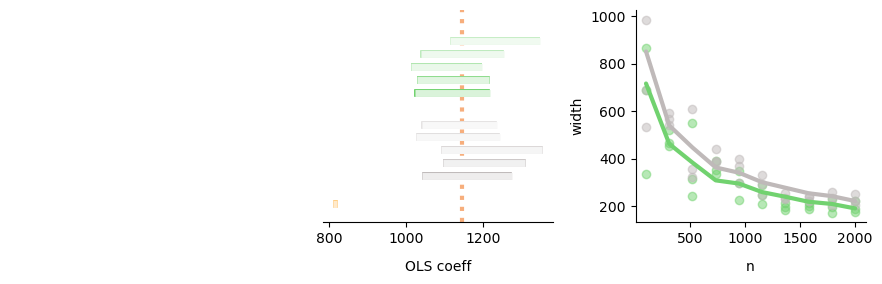

In [8]:
make_plots(
    df,
    "./plots/census_income_covshift.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
    empty_panel=True,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \theta^* < 800$.

In [9]:
# Find n such that we reject H0: OLS coeff < 800 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [np.random.permutation(n_inD) for i in range(num_experiments)]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        _Yhat = Yhat_inD[rand_idx[:n]]
        importance_weights = np.array(
            [
                weights[0] / inD_weights[0]
                if z == 0
                else weights[1] / inD_weights[1]
                for z in _Z
            ]
        )

        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, w=importance_weights, alpha=alpha
        )

        if ppi_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        _Yhat = Yhat_inD[rand_idx[:n]]
        importance_weights = np.array(
            [
                weights[0] / inD_weights[0]
                if z == 0
                else weights[1] / inD_weights[1]
                for z in _Z
            ]
        )

        classical_ci = ppi_ols_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, w=importance_weights, alpha=alpha, lhat=0
        )

        if classical_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [10]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 100, 10000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=248 labeled data points to reject the null.
The classical test requires n=301 labeled data points to reject the null.
